In [1]:
%pylab
%matplotlib inline
import skimage as sk
import skimage.io
import skvideo
import skvideo.io
import scipy
from sklearn.preprocessing import normalize
import torchvision as tv
from tqdm import tqdm
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)
import skimage.transform
from importlib import reload
import fish_track as ft

from joblib import Parallel, delayed

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
reload(ft)

<module 'fish_track' from '/home/ubuntu/fish_track.py'>

In [3]:
directory = "/home/ubuntu/"
# filename = "20180410_1.mp4"
filename = "20180109_2.mp4"
vid_file = directory+filename

In [4]:
firstFrame = ft.get_first_frame(vid_file)

In [5]:
frames = ft.get_n_frames(vid_file)

# ROI selection

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


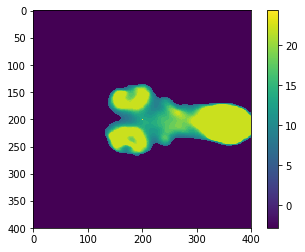

In [32]:
pad = 100
maxThreshold = 25
minThreshold = 10
ds_factor=1
downsample = lambda x: skimage.transform.resize(x,np.array(firstFrame.shape[:2])/ds_factor)
frame = downsample(firstFrame)
frame = np.full([pad*2+frame.shape[0],pad*2+frame.shape[1]], 1)
fishroiframe = downsample(firstFrame)
frame[pad:-pad,pad:-pad] = downsample(denoise_tv_chambolle(frames[11,:,:,0]).copy()*255)
frame[frame>maxThreshold] = maxThreshold
frame[frame<minThreshold] = 0
# plt.imshow(frame)
# plt.colorbar()

# fc = np.array(2)
fishCenter = (pad+235,pad+190)
# fishCenter = (pad+117,pad+95)
# fishCenter = (pad+59,pad+47)
pad = int(200/ds_factor)

fishROI = ft.selectROI(frame,fishCenter, pad)

# fishROI = normalize(fishROI, norm='l2')
fishROI = fishROI - fishROI.mean()
# fishROI = (fishROI - fishROI.mean())/fishROI.std()
# fishROI = fishROI - fishROI.sum()/len(fishROI)
fishROI = fishROI.astype(float32)

fishROI[pad,pad] = np.max(fishROI)*1.1
plt.imshow(fishROI)
plt.colorbar()
imageW, imageH = frame.shape

In [33]:
def selectROI(img,center,pad):
    return img[center[0]-pad:center[0]+pad,center[1]-pad:center[1]+pad]

def rotateImage(img, angle, pivot):
    padX = [img.shape[1] - pivot[1], pivot[1]]
    padY = [img.shape[0] - pivot[0], pivot[0]]
    imgP = np.pad(img, [padY, padX], 'constant')
    imgR = scipy.ndimage.rotate(imgP, angle, reshape=False)
    return imgR[padY[0] : -padY[1], padX[0] : -padX[1]]

def ROI_to_filters(img, center, pad, imageW, imageH, nfilters=8, fft=False, dtype=np.float64):
    filter_size = 2*pad
    # we will use the center of the img plus a pad to create rotationally invariant filters
    filters = np.zeros([nfilters,filter_size,filter_size])
    norm = (img - img.mean()).astype(dtype) # subtract mean
    for i in range(nfilters):
        # rotate the image first around the provided pivot
        rot = rotateImage(norm, i * 360 / nfilters, center)
        # select the ROI for the filter
        filters[i] = np.fliplr(rot[center[0]-pad:center[0]+pad,center[1]-pad:center[1]+pad])
        
    if fft:
        pass
#         complex_filters = T.cuda.FloatTensor(nfilters,imageW*2, imageH*2, 2).zero_()
#         complex_filters[:,0:filter_size,0:filter_size,0] = T.from_numpy(filters)
#         return T.fft(complex_filters,2)
    else:
        return filters.astype(dtype)
dtype = np.float32
filters = ROI_to_filters(frame, fishCenter, pad, imageW, imageH, 8,dtype=dtype)
# filters_fft = ft.ROI_to_filters(frame, fishCenter, pad, imageW, imageH, 32, fft=True)

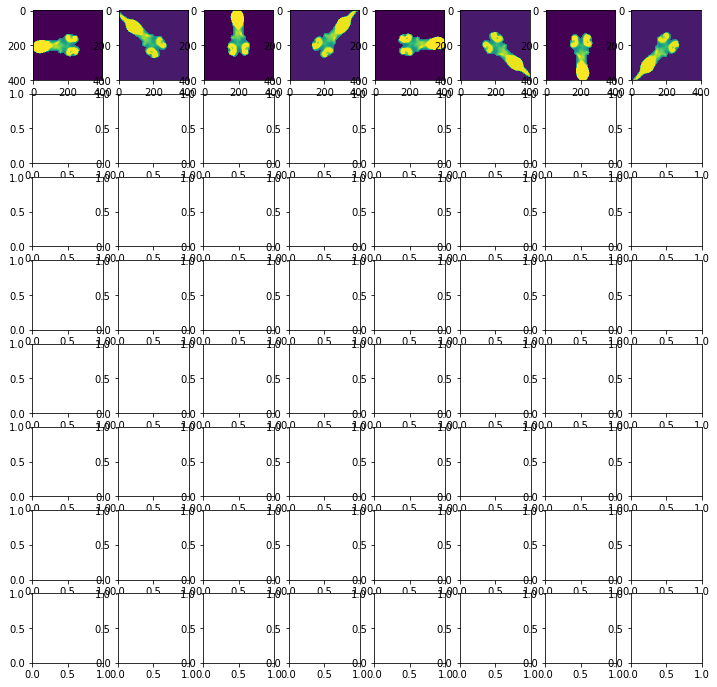

In [34]:
nrow = 8
ncol = 8
plt.subplots(nrow,ncol,figsize=(12,12))
for i in range(filters.shape[0]):
    plt.subplot(nrow,ncol,1+i)
    plt.imshow(filters[i].astype(np.float32))

In [35]:
f = frames[0]
img = downsample(f[:,:,0].astype(np.float64)).astype(dtype)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


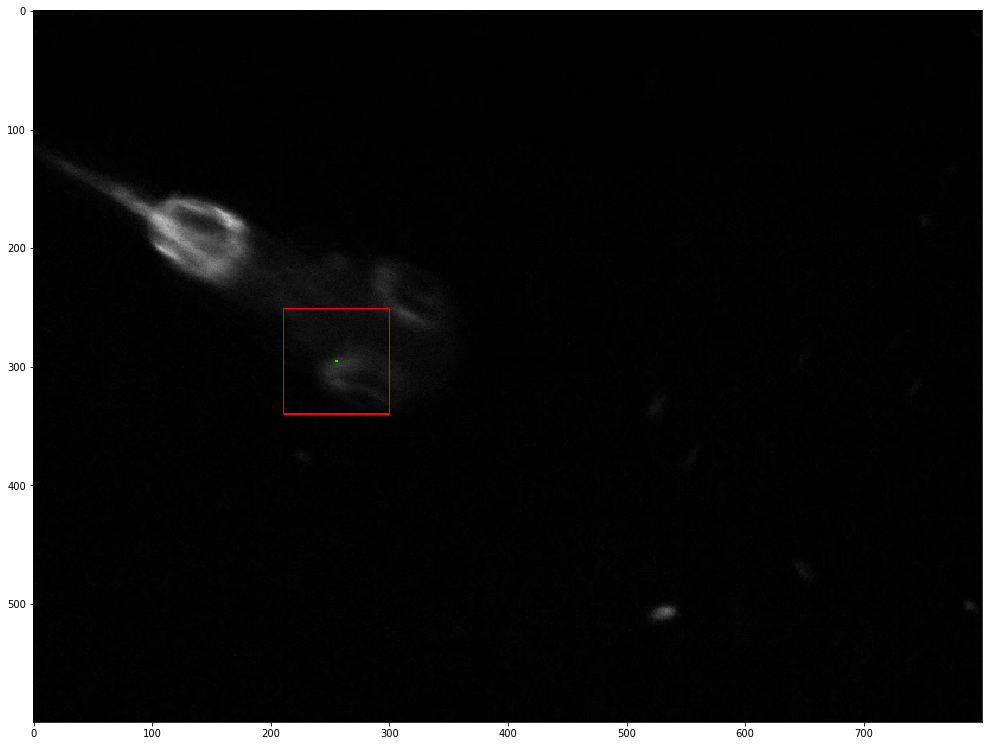

In [36]:
def find_position_scipy_parallel(img, w, parallel):
    hm = np.array(parallel(
        delayed(scipy.signal.convolve)(img,w[i],mode='same')
        for i in range(w.shape[0])))
    idx = hm.argmax()
    y, x = np.unravel_index(idx, hm.shape)[1:]
    return y, x

def find_position_scipy(img, w, n_jobs=8):
    with Parallel(n_jobs=n_jobs) as parallel:
        hm = np.array(parallel(
            delayed(scipy.signal.convolve)(img,w[i],mode='same')
            for i in range(w.shape[0])))
    idx = hm.argmax()
    y, x = np.unravel_index(idx, hm.shape)[1:]
    return y, x

def heatmap_scipy(img, w, n_jobs=8):
    with Parallel(n_jobs=n_jobs) as parallel:
        hm = np.array(parallel(
            delayed(scipy.signal.convolve)(img,w[i],mode='same')
            for i in range(w.shape[0])))
    return hm
pos = find_position_scipy(img,filters)
plt.figure(figsize=(17,17))
plt.imshow(ft.drawROI(downsample(f),*pos,1,45,1))

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(8, 600, 800)
Best: filter=5, x=296, y=256


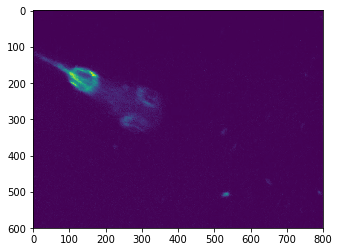

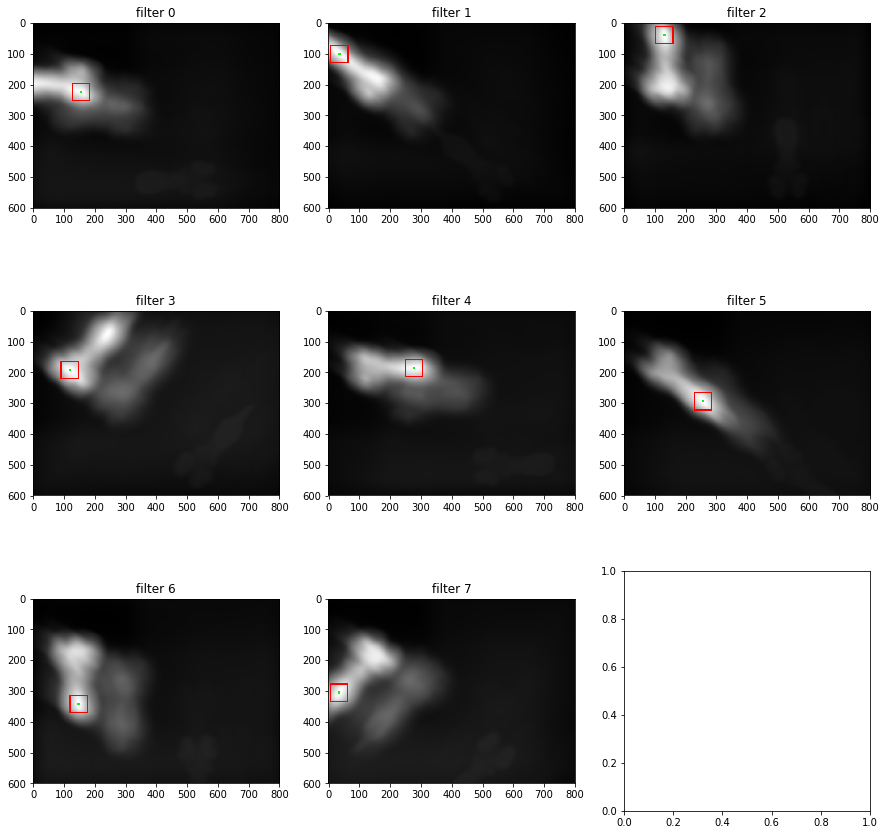

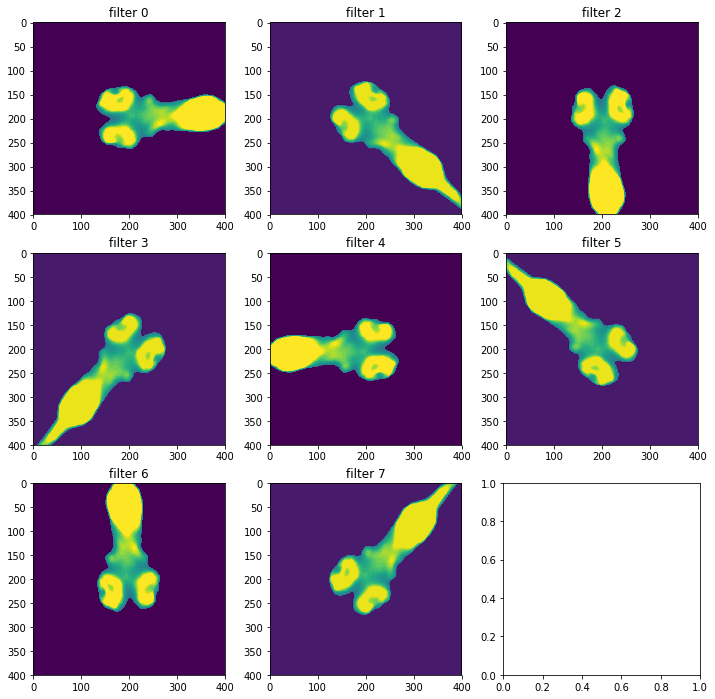

In [37]:
def viz_find_position(img, filters, fft=False,dtype=np.float32):
    nrow = int(np.ceil(np.sqrt(filters.shape[0])))
    ncol = nrow
    plt.imshow(img)
    hm = heatmap_scipy(img,filters)
    print(hm.shape)
    print("Best: filter={}, x={}, y={}".format(*np.unravel_index(np.argmax(hm),hm.shape)))
    plt.subplots(nrow,ncol,figsize=(15,15))
    for i in range(hm.shape[0]):
        plt.subplot(nrow,ncol,1+i)
        h = hm[i]
        m = np.unravel_index(np.argmax(h),h.shape)
        image = ft.drawROI(ft.scale_range(h[:,:,None],0,1).repeat(3,2),m[0],m[1],4,30,4,use_float=True)
        plt.imshow(image)
        plt.title("filter {}".format(i))

    plt.subplots(nrow,ncol,figsize=(12,12))
    for i in range(hm.shape[0]):
        plt.subplot(nrow,ncol,1+i)
        f = np.flipud(np.fliplr(filters[i]))
        plt.imshow(f)
        plt.title("filter {}".format(i))

f = frames[0]
img = downsample(f[:,:,0].astype(np.float64)).astype(dtype)
viz_find_position(img, filters)

In [38]:
%%timeit -r 1 -n 1
with Parallel(n_jobs=8) as parallel:
    for i in range(100):
        find_position_scipy_parallel(img, filters,parallel)

18.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


# FFT conv validation (failing)

In [38]:
def heatmap_fft(img, w):
    fimg = T.cuda.FloatTensor(*w.shape[1:]).zero_()
    fimg[:,:,0] = T.from_numpy(img).cuda()
    conv = T.ifft(T.fft(fimg,2)*w,2)
    return conv[:,:,:,0]

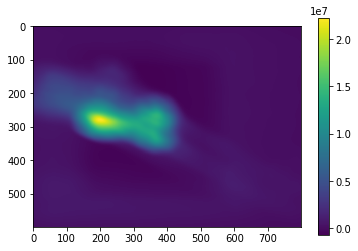

In [17]:
plt.imshow(ft.heatmap(img, filters).cpu().numpy()[0].astype(np.float64))
plt.colorbar()

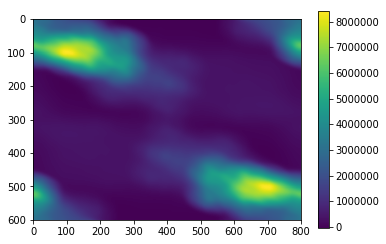

In [39]:
plt.imshow(heatmap_fft(img, filters_fft)[0])
plt.colorbar()

Best: filter=13, x=206, y=146


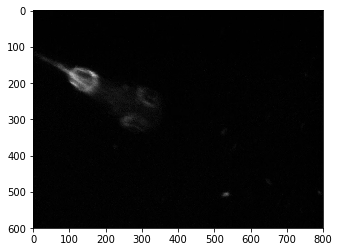

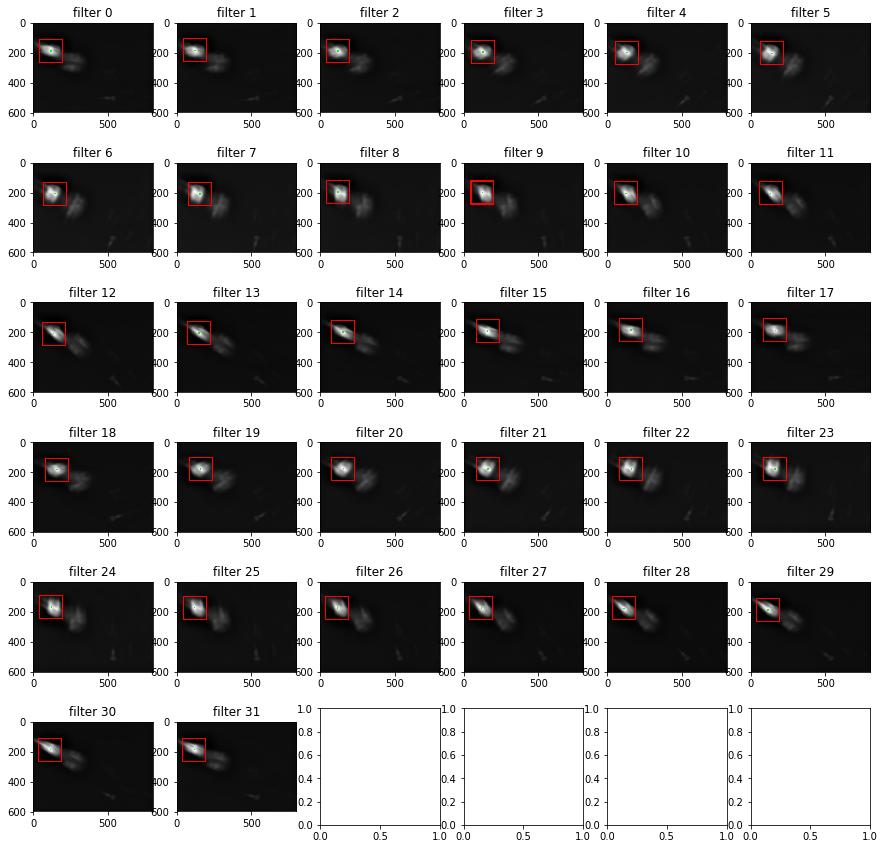

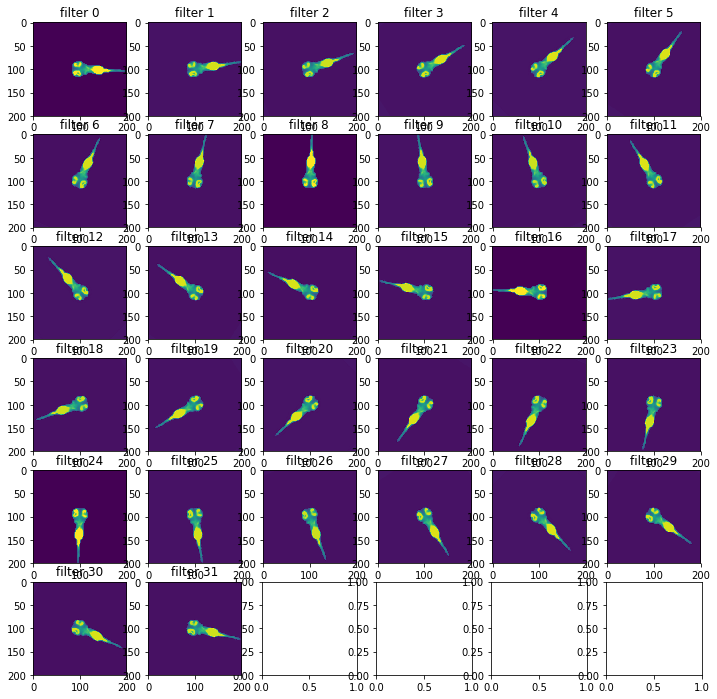

In [46]:
viz_find_position(frames[0], filters)

In [31]:
reload(ft)

<module 'fish_track' from '/home/ubuntu/fish_track.py'>

Best: filter=15, x=14, y=11


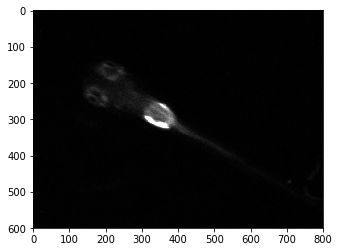

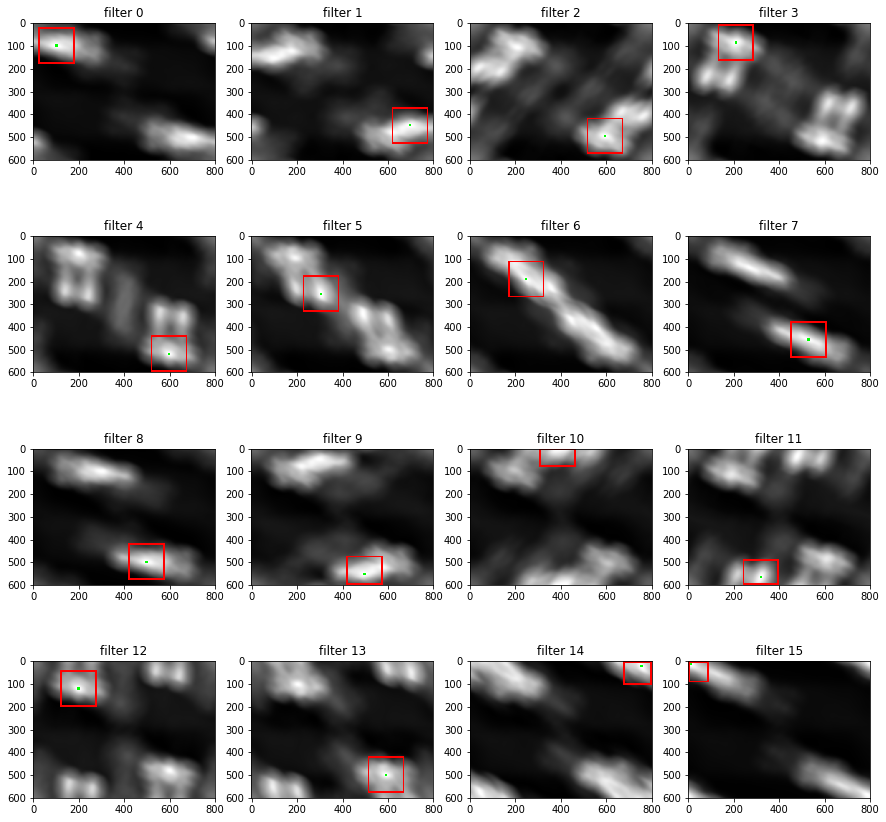

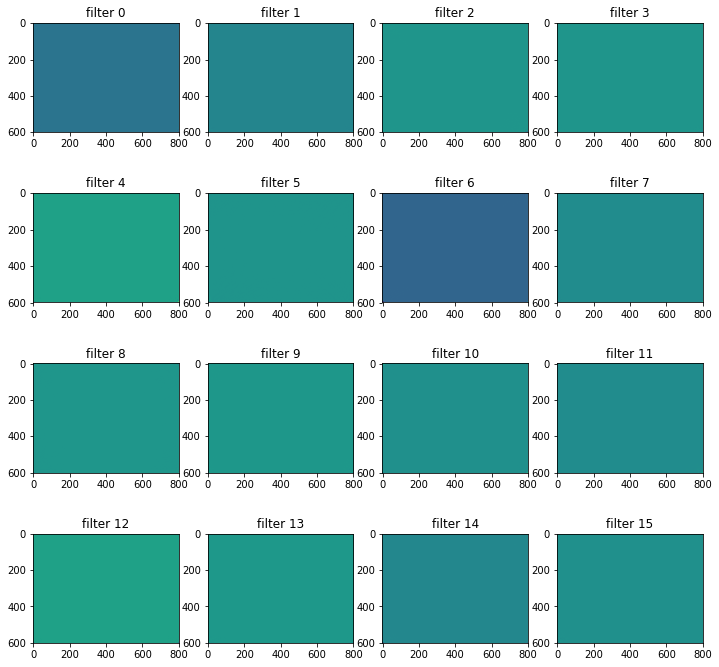

In [35]:
viz_find_position(frames[7], filters_fft, fft=True)

# Create tracking video

In [ ]:
def drawROI(img, y, x, width=20,dot=1):
    colorimg = img.copy()
    colorimg[y-dot:y+dot,x-dot:x+dot] = [0,255,0]

    ystart = max(0,y-width)
    yend = min(img.shape[0]-1,y+width)
    xstart = max(0,x-width)
    xend = min(img.shape[1]-1,x+width)
    colorimg[ystart:yend,xstart] = [255,0,0]
    colorimg[ystart:yend,xend] = [255,0,0]
    colorimg[ystart,xstart:xend] = [255,0,0]
    colorimg[yend,xstart:xend] = [255,0,0]
    return colorimg

In [16]:
# with Parallel(n_jobs=8) as parallel:
#     hm = find_position_scipy(img, filters, parallel)

def write_video_scipy(filters, input_vid_filename, output_vid_filename,nframes=1e4,
                      nskip=1e1, downsample=4,dtype=dtype):
    vid_gen = skvideo.io.vreader(input_vid_filename)
    writer = skvideo.io.FFmpegWriter(output_vid_filename)
    firstFrame = ft.get_first_frame(input_vid_filename)
    ds = lambda x: skimage.transform.resize(x,np.array(firstFrame.shape[:2])/downsample)
    with Parallel(n_jobs=8) as parallel:
        for t, frame in tqdm(enumerate(vid_gen)):
            if t % 10 ==0:

                img = ds(frame[:,:,0]).astype(np.float32)
                y,x = find_position_scipy_parallel(img, filters, parallel)
                y = y*4
                x = x*4
                f = ft.drawROI(frame,y,x,2,90,1)
                writer.writeFrame(f)
            if t > 1000*10:
                break
        writer.close()

write_video_scipy(filters, vid_file, directory + "track_close_4xdown_64filt_" + filename,nframes=1e4,nskip=1e1)


0it [00:00, ?it/s]/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "

1it [00:00,  2.29it/s]
11it [00:00, 15.51it/s]
21it [00:00, 21.43it/s]
31it [00:01, 25.05it/s]
41it [00:01, 27.93it/s]
51it [00:01, 29.68it/s]
61it [00:01, 32.27it/s]
71it [00:02, 33.91it/s]
81it [00:02, 35.43it/s]
91it [00:02, 35.92it/s]
101it [00:02, 36.14it/s]
111it [00:03, 36.78it/s]
121it [00:03, 37.77it/s]
131it [00:03, 37.92it/s]
141it [00:03, 38.45it/s]
151it [00:03, 39.11it/s]
161it [00:04, 38.98it/s]
171it [0

In [12]:
with Parallel(n_jobs=8) as parallel:
    pass

In [66]:
hm

(114, 119)